## Indetermined Sugar Losses Prediction Model for Pantaleon Sugar Mills

The present model can be used to forecast indeterminate losses in the industrial process based on the harvest day (called Dia de Zafra).

The dependency is modeled over the "harvest day" instead of an actual date because this isolates variations coming from sugar cane quality, ripeners applications, harvesting schedule, etc, which are all adjusted to begin on the first day of harvesting.

### Model Selection
A **Gaussian Process** model is selected in order to find a family of non-linear functions capable of aproximate the indetermined sugar losses as a function of the day of harvest. This is a more powerful tool than a Time Series model because it captures the cyclic pattern of the sugar loss between harvest seasons, and allows for interpolation for any given harvest day.

For this develpment, a Gaussian Process regression was perform over six different sugar cane harvest seasons. Experiments were performed for a Radial Basis Function Kernel (RBF) and White Noise Kernel (White Kernel) in order to account for noise over the observation. The model is train over the whole dataset. 


#### The RBF Kernel.

Radial basis function kernel (aka squared-exponential kernel).

The RBF kernel is a stationary kernel. It is also known as the “squared exponential” kernel. It is parameterized by a length scale parameter , which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel). 

The kernel is given by:

<center> $k(x_i, x_j) = \exp\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$ </center>
 
where ***l*** is the length scale of the kernel and $d(\cdot,\cdot)$ is the Euclidean distance. This kernel is infinitely differentiable, which implies that GPs with this kernel as covariance function have mean square derivatives of all orders, and are thus very smooth.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK

%matplotlib inline

In [2]:
# Function to show the summary of the fit
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n\n%s" % gp.kernel_
    s2 = "\n\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    print(s1 + s2 + '\n')

### Indeterminate Sugar Losses Dataset
This dataset contains dialy information about several process and quality variables for the sugar loss determination, and also the actual sugar loss (in kg/t and % of the total available sugar) for the following harvest seasons:**18-19, 19-20, 20-21, 21-22 y 22-23**.  

The **Indeterminate Sugar Loss** refers to *any amount of sugar loss that occurs in the process but whose nature cannot be determined*.

This Gaussian Process approach is not intended for finding possible causes for the sugar loss, but rather predicting what the value would be based on the day of harvest.

In [3]:
df_all = pd.read_csv(r'C:\Users\100346\OneDrive - Pantaleon. S.A\Desktop\DataScience\Perdidas Indeterminadas\Indeterminadas_Dataset.csv')
df_all

,Dia Zafra,Zafra,Caña Recibida (t),Caña Molida (t/h),Caña molida (t),Tiempo perdido total (%),"Rendimiento core sampler, kg/t",Pureza del jugo del core.,Brix del jugo del core,"Pol en caña industrial, kg/t",...,X_TemperaturaEntradaJugoEfecto3(°F),X_TemperaturaEntradaJugoEfecto4(°F),X_TemperaturaEntradaJugoEfecto5(°F),X_PromedioEfectoA(m3),X_PromedioEfectoB(m3),X_PromedioEfectoC(m3),X_PromedioEfectoD(m3),X_PromedioEfectoE(m3),"Pérdidas indeterminadas, kg/t.","Pérdidas indeterminadas, %."
0,1,2018,19844.49,817.5025,19620.06,NaN,126.753,85.1338,18.0808,119.424,...,178.786426,204.475246,118.039420,17.470000,25.970000,24.550000,18.890000,18.470000,17.140,13.522362
1,2,2018,18078.33,975.4198,17862.28,5.6828,130.967,86.4462,18.4819,123.539,...,194.382779,205.388373,117.619035,16.740000,29.450000,36.250000,43.140000,49.810000,25.084,19.152916
2,3,2018,21151.76,970.6520,20923.77,2.3743,133.785,86.7075,18.6096,130.110,...,220.488595,210.443774,127.018799,16.550000,32.160000,27.060000,25.860000,32.490000,10.542,7.879807
3,4,2018,21311.77,982.1965,21064.51,2.5469,129.713,86.5522,18.1200,124.895,...,214.828661,156.406877,151.932359,15.390000,34.390000,35.510000,42.620000,56.440000,13.474,10.387548
4,5,2018,23729.85,1036.4215,23428.26,1.3915,127.029,86.0435,17.7319,125.306,...,215.862081,201.815702,147.765442,16.670000,32.490000,36.710000,41.770000,52.750000,7.424,5.844335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,53,2023,27869.93,1363.6073,27698.91,3.4582,129.702,86.0924,18.0717,127.600,...,204.696976,200.616690,163.587018,33.499119,26.618702,26.237275,29.194657,37.290184,5.412,4.172642
955,54,2023,32379.22,1407.1000,32143.56,1.1053,128.887,86.2726,17.9614,127.830,...,187.165837,199.997527,175.743297,31.612492,28.908118,27.638745,44.098971,52.907247,5.722,4.439548
956,55,2023,29022.25,1374.2275,28793.10,2.6140,128.418,86.3441,18.1156,127.203,...,203.641181,198.204291,153.772455,33.142266,31.745407,34.609043,45.276095,46.257271,7.721,6.012397
957,56,2023,28877.13,1376.1949,28660.07,2.9654,126.449,86.0244,17.6457,125.859,...,205.039011,194.813060,166.979608,32.079982,23.660741,27.590576,36.402130,39.254304,3.854,3.047869


### Gaussian Process Training
The training can be performed filtering by an specific harvest season. For this analysis, all the available harvest seasons will be used for training.
The performance metric to be optimized is the Log-Likelihood. The final product is a probabilistic model using an RBF + WK kernels.

### Indetermined Sugar Loss Forecasting.
The forecast consists of the model application over a specific range of "days of the harvest" (DIA ZAFRA).

For each day of the harvest, a **conditional probability distribution** is generated. This allows for a single value prediction (expected value of the conditional distribution) but also a confidence interval in order to get an estimate of the *probability that this confidence interval contains the prediction*, when new data is used for the model.

This is particularly useful when analyzing scenarios, where a **confidence level** is required for every prediction.

For every prediction, the following is shown:
- The expected value of the conditional distribution (forecasted value).
- The standard deviation of the prediction (for building confidence intervals under a Gaussian Model).
- Functions sampled from the conditional distributions for simulated scenarios.


### KARBE ALL YEARS

In [4]:
# Specify observations
df_todos = df_all
#df_todos = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022) | (df_all['Zafra'] == 2021)] # example filtering seasons 2023, 2022 and 2021
#df_todos = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022)] # example filtering seasons 2023 and 2022

df_todos = df_todos.drop(df_todos[df_todos['Pérdidas indeterminadas, %.'] == 0].index)
y = df_todos['Pérdidas indeterminadas, %.'].values
X = np.array(df_todos['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 1e2)) + WK(1)
gp_todos = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_todos.fit(X, y)
summary(gp_todos)

Fitted Kernel(Optimized)

10.6**2 * RBF(length_scale=10.4) + WhiteKernel(noise_level=6.99)

log marginal likelihood: -2401.76299



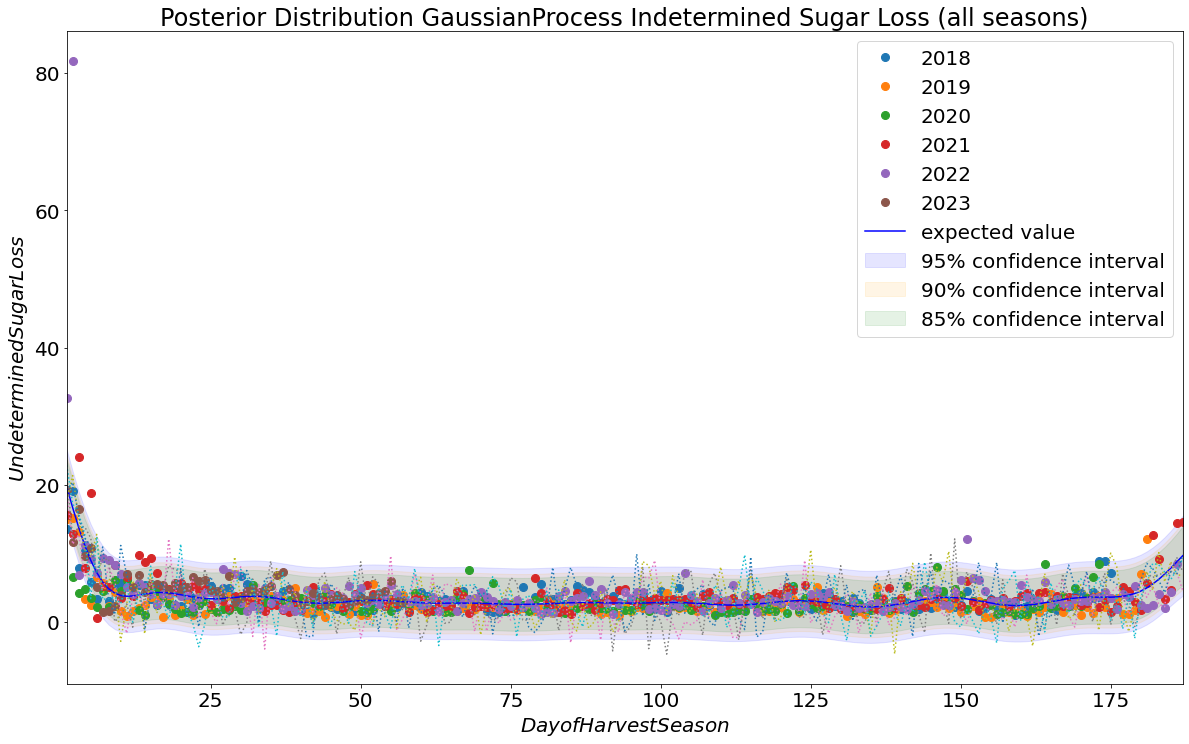

In [5]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 187, 187), ndmin = 2).T
f_mean, f_var = gp_todos.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
X_plot = df_todos['Dia Zafra']
y_plot = df_todos['Pérdidas indeterminadas, %.']
labels = df_todos['Zafra']
df_plot = pd.DataFrame(dict(x=X_plot, y=y_plot, label=labels))
groups = df_plot.groupby('label')

# Plot
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=8, label=name)

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='expected value')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='95% confidence interval')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='90% confidence interval')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='85% confidence interval')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 187, 187), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_todos.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Day of Harvest Season$')
plt.ylabel('$Undetermined Sugar Loss %$')
plt.xlim(X_test.min(), X_test.max())
plt.legend(loc='upper right')
plt.title('Posterior Distribution GaussianProcess Indetermined Sugar Loss (all seasons)')
plt.show()

Finalmente, se exporta el resultado de los pronósticos por día de zafra a un archivo CSV de salida.

In [6]:
# Generate Data
data_tcn = {'Day of Harvest': np.arange(1,188),
        'Indetermined Sugar Loss % Forecast': f_mean,
        'Indetermined Sugar Loss % Standard Deviation': f_var,
        'LI_95:': f_mean - 1.96*f_var,
        'UI_95:': f_mean + 1.96*f_var,
        'LI_90:': f_mean - 1.65*f_var,
        'UI_90:': f_mean + 1.65*f_var,
        'LI_85:': f_mean - 1.44*f_var,
        'UI_85:': f_mean + 1.44*f_var
       }

# Create DataFrame
df_salida = pd.DataFrame(data_tcn)
df_salida

,Day of Harvest,Indetermined Sugar Loss % Forecast,Indetermined Sugar Loss % Standard Deviation,LI_95:,UI_95:,LI_90:,UI_90:,LI_85:,UI_85:
0,1,19.741278,2.756238,14.339051,25.143504,15.193485,24.289070,15.772295,23.710260
1,2,16.643276,2.707609,11.336362,21.950189,12.175721,21.110830,12.744319,20.542233
2,3,13.766267,2.687230,8.499296,19.033237,9.332337,18.200196,9.896656,17.635878
3,4,11.197037,2.681080,5.942121,16.451954,6.773255,15.620819,7.336282,15.057792
4,5,8.997906,2.680245,3.744626,14.251186,4.575501,13.420310,5.138353,12.857458
...,...,...,...,...,...,...,...,...,...
182,183,6.202997,2.729587,0.853006,11.552988,1.699178,10.706816,2.272392,10.133603
183,184,6.977662,2.746540,1.594443,12.360881,2.445871,11.509454,3.022644,10.932680
184,185,7.827820,2.783386,2.372384,13.283256,3.235234,12.420406,3.819745,11.835895
185,186,8.727912,2.855113,3.131890,14.323934,4.016975,13.438849,4.616549,12.839275


In [7]:
# Print the output.
df_salida.to_csv(r'C:\Users\100346\OneDrive - Pantaleon. S.A\Desktop\DataScience\Perdidas Indeterminadas\Indetermined_Sugar_Losses_Forecast.csv')